In [1]:
from __future__ import division

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd


# Functions

### Random Walk Simulator

In [2]:
def simulate_single_random_walk():
    '''
    Runs a sinlge random walk starting in the middle of range(0,4).
    If the current_state goes outside this range, the random walk ends.
    INPUT
        NONE
    OUTPUT 
        path: list of integers. The indices that the agent covered in the random walk.
    '''
    boundaries = [0,6]
    moves = [-1, 1]
    current_state = 3
    path = []
    
    # while x is within the bounds
    while current_state > boundaries[0] and current_state < boundaries[1]:
        path.append(current_state)
        move = np.random.choice(moves)
        current_state += move
    # add terminal state
    path.append(current_state)
        
    return path


In [3]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


### TD Update Function

In [4]:
def w_update(lam, alpha, P_t_1, P_t_0, e_t, x_i):
    # e_t update per page 16 of Learning to Predict by Methods of Temporal Difference
    delta_w_t = alpha * (P_t_1 - P_t_0) * (lam * e_t + P_t_0*x_i)
    return delta_w_t

### Experiment 1 Function

In [5]:
def convergence_simulator(alpha, lam):
    '''
    Simulates Experiment 1
    INPUT 
        alpha: float. learning rate.
        lambda: float. far-sightedness of TD learning algorithm.
    OUTPUT 
        average_rmse: float. Average of RMSE values for each training set.
        rmse_standard_error: float. SE of RMSE values for each trainign set.
        weight_convergences: list of floats. List of euclidean distances between 
            weights after each iteration.
    '''
    states = [np.zeros(7) for _ in range(7)]
    for idx, state in enumerate(states):
        state[idx] = 1.0
    w = np.array([0, .5, .5, .5, .5, .5, 1])
    actual_probs = np.array([0, 1/6, 1/3, 1/2, 2/3, 5/6, 1])
    rmse_list = []
    
    for training_set in range(100):
        # paths will be a list of lists. Each sublist will be a path walked
        paths = []
        for _ in range(10):
            sequence = simulate_single_random_walk()
            paths.append(sequence)
            
        training_set_w = w.copy()
        e_t = 0
        diffs = []
        
        # We iterate until convergence or we've iterated 100x
        for _ in range(100):
            initial_weights = training_set_w.copy()
            for path in paths:
                for idx in range(len(path) - 1):
                    t = idx + 1
                    P_t_1 = np.dot(states[path[t]], training_set_w)
                    P_t_0 = np.dot(states[path[idx]], training_set_w)
                    e_t = (lam * e_t) + (states[path[idx]] * P_t_1)
                    training_set_w += w_update(
                        lam, 
                        alpha, 
                        P_t_1, 
                        P_t_0, 
                        e_t, 
                        states[path[idx]]
                    )
            diffs.append(np.linalg.norm(np.abs(training_set_w - initial_weights )))
        
        # we exclude the end locations because their values are already known
        rmse_estimate = rmse(training_set_w[1:-1], actual_probs[1:-1])
        rmse_list.append(rmse_estimate)
    
    average_rmse = np.average(rmse_list)
    rmse_standard_error = (np.std(rmse_list) / np.sqrt(len(rmse_list)))
    weight_convergence = diffs
    
    return average_rmse, rmse_standard_error, weight_convergence


### Experiment 2 Function

In [6]:
def experiment_2_paths():
    '''
    Because experiment 2 used the same paths for different lambda and alpha values,
    we are going to store the paths beforehand.
    '''
    training_sets = []
    for _ in range(100):
        paths = []
        for i in range(10):
            paths.append(simulate_single_random_walk())
        training_sets.append(paths)
    return training_sets
    
def figure_4_simulator(alpha, lam, training_sets):
    '''
    Runs simulation per experiment 2 description'
    INPUT
        alpha: float. learning rate
        lam: float. Lambda value.
        training_set: list of 100 lists of 10 lists of integers. 
            Innermost lists are paths.
    OUTPUT
        rmse_estimate: float. Average rmse.
    '''
    states = [np.zeros(7) for _ in range(7)]
    for idx, state in enumerate(states):
        state[idx] = 1.0
    w = np.array([0, .5, .5, .5, .5, .5, 1])
    actual_probs = np.array([0, 1/6, 1/3, 1/2, 2/3, 5/6, 1])
    rmse_list = []
    
    for training_set in training_sets:
        # paths will be a list of lists. Each sublist will be a path walked
        paths = []
        path_w = w.copy()
        for path in training_set:
            e_t = 0
            for idx in range(len(path) - 1):
                t = idx + 1
                P_t_1 = np.dot(states[path[t]], path_w)
                P_t_0 = np.dot(states[path[idx]], path_w)
                e_t = (lam * e_t) + (states[path[idx]] * P_t_1)
                path_w += w_update(
                    lam, 
                    alpha, 
                    P_t_1, 
                    P_t_0, 
                    e_t, 
                    states[path[idx]]
                )

        rmse_estimate = rmse(path_w[1:-1], actual_probs[1:-1])
        rmse_list.append(rmse_estimate)
        
    return np.average(rmse_list)


# Simulations

### Experiment 1 Simulation

In [7]:
figure_3_alpha = .01
lambda_values = [0, .1, .3, .5, .7, .9, 1]
figure_3_rmses = []
sigmas = []
diffs = []
for l in lambda_values:
    rmse_val, sigma, diff = convergence_simulator(alpha=figure_3_alpha, lam=l)
    sigmas.append(sigma)
    diffs.append(diff)
    figure_3_rmses.append(rmse_val)

In [8]:
sigs = sigmas[:-1]
print "The average standard error in our RMSE across training sets:", np.round(np.mean(sigs), 3)

The average standard error in our RMSE across training sets: 0.007


In [9]:
alpha_vals = np.arange(0,0.65, .05)
t_sets = experiment_2_paths()

lam_0_curve = [figure_4_simulator(alpha=a, lam=0, training_sets=t_sets) for a in alpha_vals]
lam_3_curve = [figure_4_simulator(alpha=a, lam=.3, training_sets=t_sets) for a in alpha_vals]
lam_8_curve = [figure_4_simulator(alpha=a, lam=.8, training_sets=t_sets) for a in alpha_vals]
lam_1_curve = [figure_4_simulator(alpha=a, lam=1, training_sets=t_sets) for a in alpha_vals]


# Plots

### Ensuring that weights converge for experiment 1

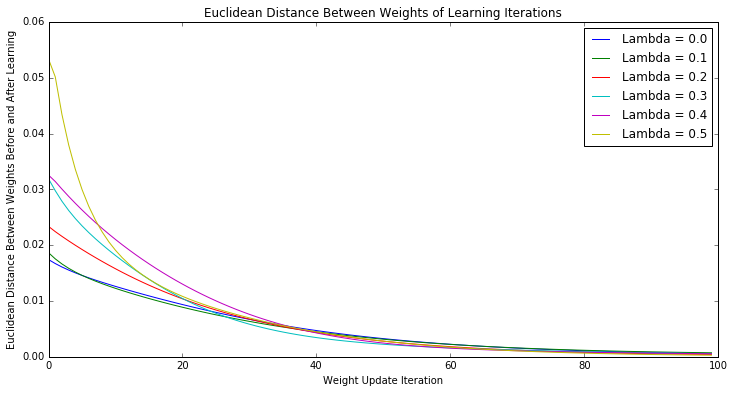

In [19]:
for idx, diff in enumerate(diffs[:-1]):
    plt.plot(range(len(diff)), diff, label="Lambda = {}".format(lambda_values[idx]))

plt.rcParams['figure.figsize'] = (10, 5)
plt.title("Euclidean Distance Between Weights of Learning Iterations")
plt.xlabel("Weight Update Iteration")
plt.ylabel("Euclidean Distance Between Weights Before and After Learning")
plt.legend()

### Experiment 1 Results

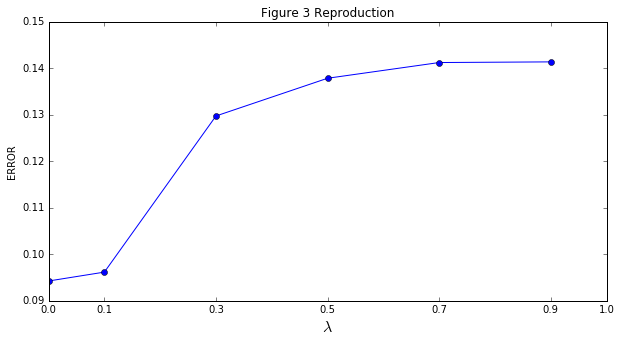

In [11]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.plot(lambda_values, figure_3_rmses, 'o-')
plt.xlabel(r'$\lambda$', fontsize=16)
plt.ylabel('ERROR')
plt.xticks(lambda_values)
plt.title("Figure 3 Reproduction")
plt.show()

### Experiment 2 Results

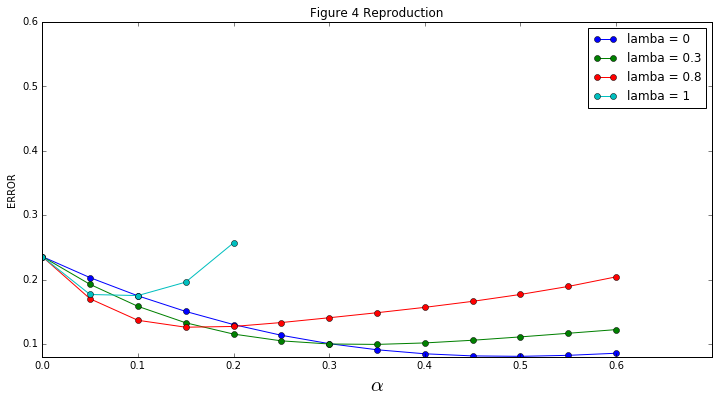

In [12]:
curves = [lam_0_curve, lam_3_curve, lam_8_curve, lam_1_curve]
lambda_values = [0, .3, .8, 1]

plt.rcParams['figure.figsize'] = (12, 6)

for lam, curve in zip(lambda_values, curves):
    plt.plot(alpha_vals, curve, 'o-', label='lamba = {}'.format(lam))
    
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel('ERROR')
plt.xticks(np.arange(0, .7, .1))
plt.yticks(np.arange(0.1, .7, .1))
plt.legend()
plt.title("Figure 4 Reproduction")
plt.show()


### Finding optimal $\alpha$ for each $\lambda$

In [13]:
lambda_values = np.arange(0, 1.1, 0.1)
alpha_range = np.arange(.1, .6, .02)
best_alphas = []
rmse_values = []

for l in lambda_values:
    current_min_rmse = 100
    current_best_alpha = 0
    for a in alpha_range:
        rmse_val = figure_4_simulator(alpha=a, lam=l, training_sets=t_sets)
        if rmse_val < current_min_rmse:
            current_min_rmse = rmse_val
            current_best_alpha = a
    best_alphas.append(current_best_alpha)    
    rmse_values.append(current_min_rmse)

### Figure 5 

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
lr = LinearRegression()
lr.fit(lambda_values.reshape(-1,1), np.array(best_alphas))
r_squared = lr.score(lambda_values.reshape(-1,1), best_alphas)
print "R Squared of Linear Fit: ", r_squared

R Squared of Linear Fit:  0.988723205965


/Users/Trent/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


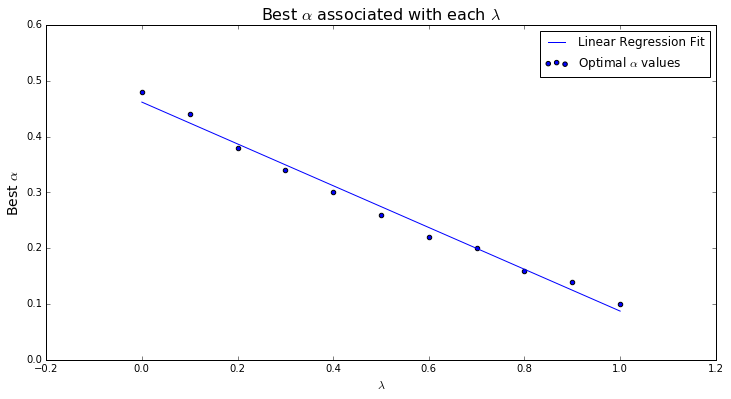

In [17]:
plt.scatter(lambda_values, best_alphas, label= r"Optimal $\alpha$ values")
plt.plot(lambda_values, lr.predict(lambda_values.reshape(-1, 1)), label='Linear Regression Fit')
plt.xlabel(r"$\lambda$", fontsize = 12)
plt.ylabel(r"Best $\alpha$", fontsize = 14)
plt.title(r"Best $\alpha$ associated with each $\lambda$", fontsize=16)
plt.legend()
plt.show()

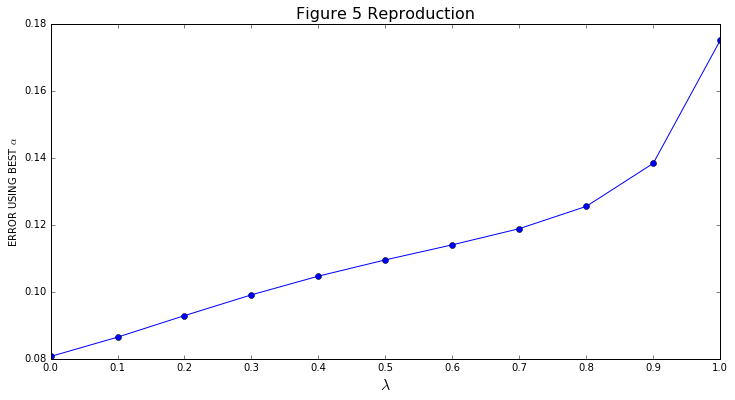

In [18]:
plt.plot(lambda_values, rmse_values, "o-")
plt.title("Figure 5 Reproduction", fontsize=16)
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"ERROR USING BEST $\alpha$")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(.08, .20, .02))
plt.show()

### Simulate Experiment 1 for different $\alpha$ values

In [22]:
alphas = [.01, .1, .3, .5]
for a in alphas:
    average_rmse, rmse_standard_error, weight_convergence  = convergence_simulator(a, 0.3)
    print "Alpha: ", a
    print "RMSE: ", average_rmse
    print "Average Standard Error: ", rmse_standard_error, "\n\n"

Alpha:  0.01
RMSE:  0.118611480413
Average Standard Error:  0.00634309511201 


Alpha:  0.1
RMSE:  0.13325362107
Average Standard Error:  0.00716748269032 


Alpha:  0.3
RMSE:  0.12806266
Average Standard Error:  0.00613696331673 


Alpha:  0.5
RMSE:  0.127831243665
Average Standard Error:  0.00563814529224 




### Simulate Experiment 1 for different Initial Weights

In [27]:
def convergence_simulator_2(alpha, lam, weights):
    '''
    Simulates Experiment 1
    INPUT 
        alpha: float. learning rate.
        lambda: float. far-sightedness of TD learning algorithm.
        weights: numpy array of floats. 
    OUTPUT 
        average_rmse: float. Average of RMSE values for each training set.
        rmse_standard_error: float. SE of RMSE values for each trainign set.
        weight_convergences: list of floats. List of euclidean distances between 
            weights after each iteration.
    '''
    states = [np.zeros(7) for _ in range(7)]
    for idx, state in enumerate(states):
        state[idx] = 1.0
    w = weights
    actual_probs = np.array([0, 1/6, 1/3, 1/2, 2/3, 5/6, 1])
    rmse_list = []
    
    for training_set in range(100):
        # paths will be a list of lists. Each sublist will be a path walked
        paths = []
        for _ in range(10):
            sequence = simulate_single_random_walk()
            paths.append(sequence)
            
        training_set_w = w.copy()
        e_t = 0
        diffs = []
        
        # We iterate until convergence or we've iterated 100x
        for _ in range(100):
            initial_weights = training_set_w.copy()
            for path in paths:
                for idx in range(len(path) - 1):
                    t = idx + 1
                    P_t_1 = np.dot(states[path[t]], training_set_w)
                    P_t_0 = np.dot(states[path[idx]], training_set_w)
                    e_t = (lam * e_t) + (states[path[idx]] * P_t_1)
                    training_set_w += w_update(
                        lam, 
                        alpha, 
                        P_t_1, 
                        P_t_0, 
                        e_t, 
                        states[path[idx]]
                    )
            diffs.append(np.linalg.norm(np.abs(training_set_w - initial_weights )))
        
        # we exclude the end locations because their values are already known
        rmse_estimate = rmse(training_set_w[1:-1], actual_probs[1:-1])
        rmse_list.append(rmse_estimate)
    
    average_rmse = np.average(rmse_list)
    rmse_standard_error = (np.std(rmse_list) / np.sqrt(len(rmse_list)))
    weight_convergence = diffs
    
    return average_rmse, rmse_standard_error, weight_convergence

In [28]:
w_1 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
w_2 = np.array([0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
rmse_1, se_1, wc_1 = convergence_simulator_2(0.1, .3, w_1)
rmse_2, se_2, wc_2 = convergence_simulator_2(0.1, .3, w_2)

print "RMSE 1:", rmse_1
print "Standard Error 1:", se_1, "\n\n"
print "RMSE 2:", rmse_2
print "Standard Error 2:", se_2

RMSE 1: 0.125299811154
Standard Error 1: 0.00762756968296 


RMSE 2: 0.117898133899
Standard Error 2: 0.00673260668674
